# DNN02_Predict Taxi Fare Project(심층신경망을 이용한 택시요금 예측)
  
###### 2024-3-05 KH.LIM @Cheongju MyHappyHome
###### 신경망 교과서 참조
###### over96@naver.com

택시를 호출하기 전에 예상 요금을 예측하는 것은 쉽지 않다.  
요금을 정확하게 예측하려면 교통 상황, 시각, 승차 위치 및 하차 위치 등 다양한 환경 변화와 변수를 고려해야 한다. 
이 프로젝트에서는 심층 신경망을 이용해서 택시요금을 예측하려 한다.

캐글에 공개된 뉴욕시 택시 요금 데이터셋을 사용한다.  
2009년부터 2015년까지 5,500만 회 운행 기록이다.  

## 탐색적 데이터 분석

In [1]:
import pandas as pd

df = pd.read_csv('../DeeplearningTextbook/data3/NYC_taxi.csv', parse_dates=['pickup_datetime'], nrows=500000)

parse_dates에 날짜 형식 칼럼을 지정하면 날짜와 시간 연산을 쉽게 사용할 수 있다

In [6]:
print(df.head())

                             key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3 

데이터셋 칼럼  
key : 고유ID  
fare_amount : 요금(종속변수)  
pickup_datetime : 승차시간  
pickup_longitude, latitude : 승차위치(위도, 경도)  
dropoff_longitude, latitude : 하차위치(위도, 경도)
passenger_count : 승객수

### 위치 데이터 시각화

In [7]:
# 승차 및 하차 위치의 위도 경도로 점차트 그리기

# 뉴욕시의 경도 범위
min_longitude = -74.05
max_longitude = -73.75

# 뉴욕시의 위도 범위
min_latitude = 40.63
max_latitude = 40.85

df2 = df.copy(deep=True)
for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > min_longitude) & (df2[long] < max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > min_latitude) & (df2[lat] < max_latitude)]


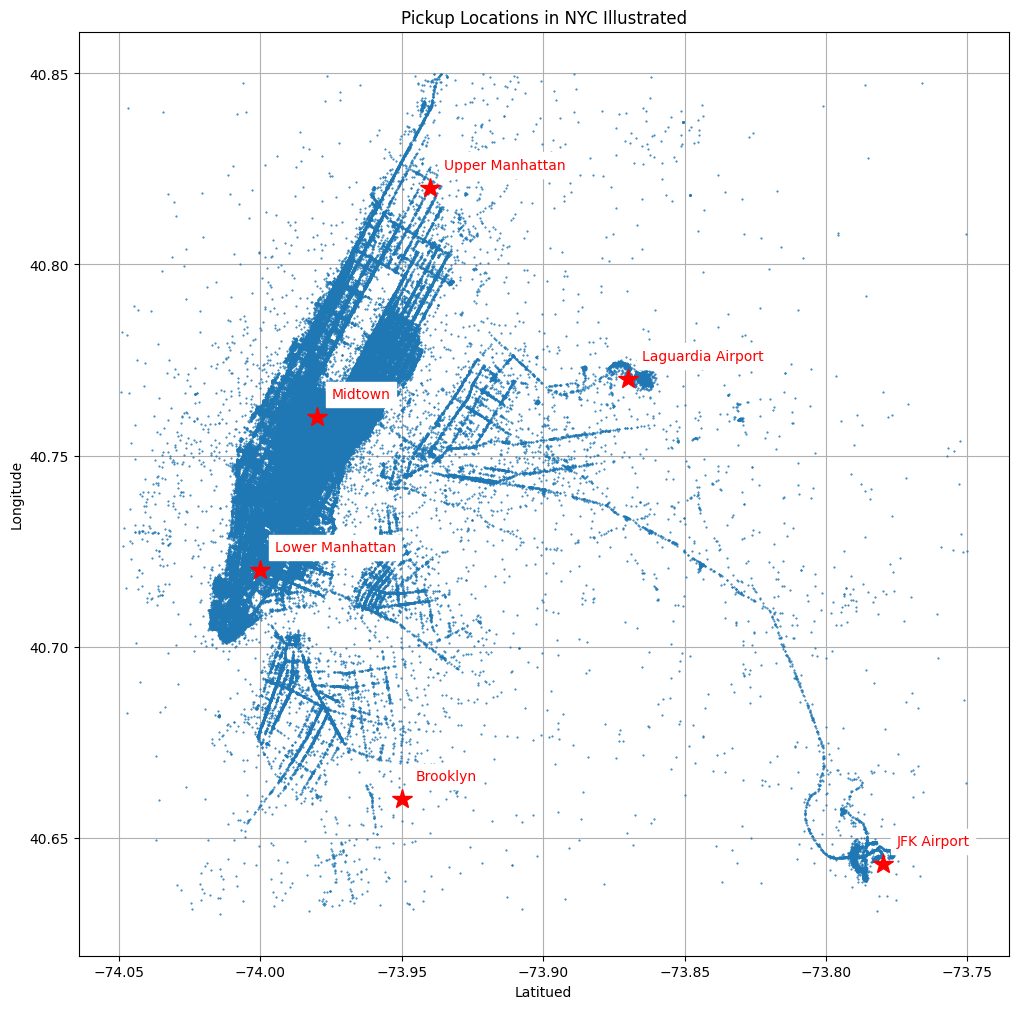

In [9]:
# 랜드마크 좌표 설정

landmarks = {'JFK Airport' : (-73.78, 40.643),
             'Laguardia Airport' : (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan' : (-74.00, 40.72),
             'Upper Manhattan' : (-73.94, 40.82),
             'Brooklyn' : (-73.95, 40.66)}

# 점차트 그리는 함수 정의

import matplotlib.pyplot as plt

def plt_lat_long(df, landmarks, points='Pickup'):
    plt.figure(figsize = (12,12))
    if points == 'Pickup':
        plt.plot(list(df.pickup_longitude), list(df.pickup_latitude), '.', markersize=1)
    else:
        plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude), '.', markersize=1)
    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], '*', markersize=15, alpha=1, color='r')  #랜드마크 표시
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, landmarks[landmark][1]+0.005), color='r', backgroundcolor='w')
    plt.title("{} Locations in NYC Illustrated".format(points))
    plt.grid(None)
    plt.xlabel("Latitued")
    plt.ylabel("Longitude")
    plt.show()
    
# 승차위치 그리기    
plt_lat_long(df2, landmarks, points= 'Pickup')

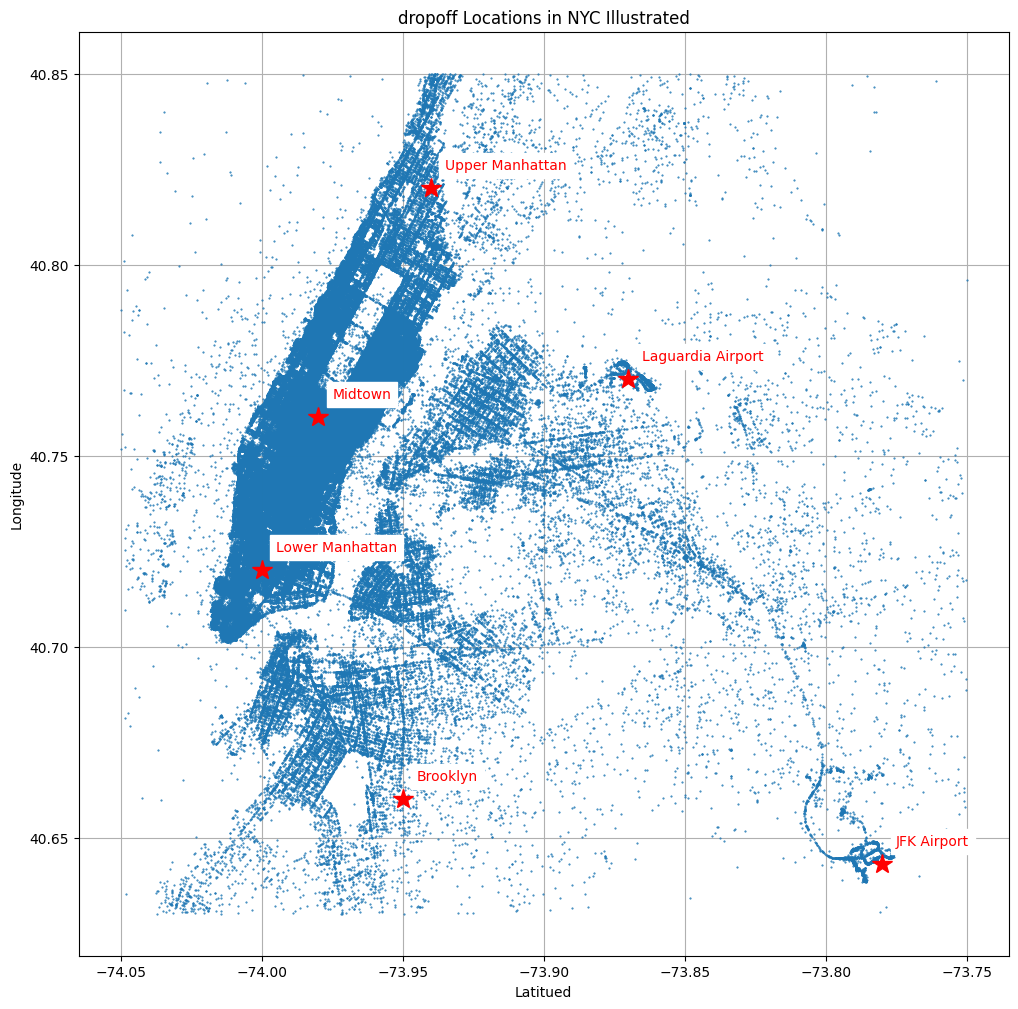

In [10]:
# 하차위치 그리기    
plt_lat_long(df2, landmarks, points= 'dropoff')

### 요일 / 시간별 승차 통계  
데이터셋에는 pickup_datetime칼럼 하나에 승차 일자 및 시간 정보가 datetime 형식으로 저장되어 있음.   
이 칼럼을 연, 월, 일, 요일, 시각으로 나눠 각각 다른 칼럼에 저장

In [11]:
import numpy as np
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

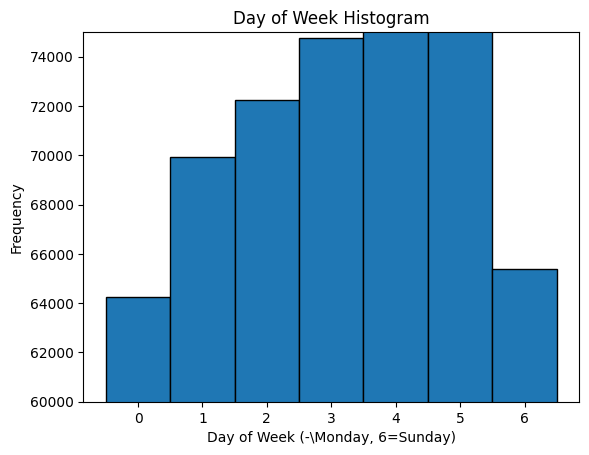

In [13]:
# 요일별 승차횟수 히스토그램

import numpy as np
df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='black', ylim=(60000, 75000))
plt.xlabel('Day of Week (-\Monday, 6=Sunday)')
plt.title('Day of Week Histogram')
plt.show()

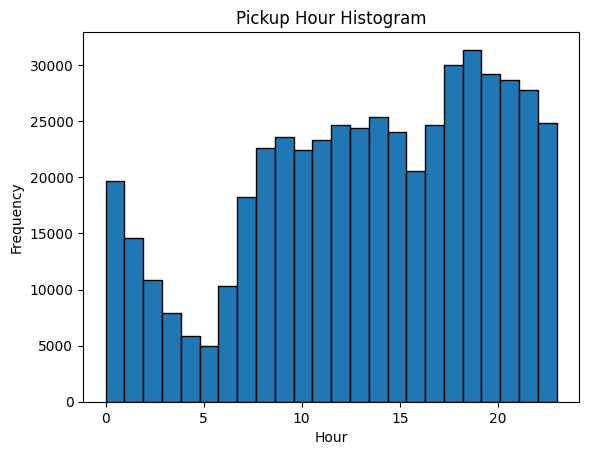

In [14]:
# 시간별 승차횟수 히스토그램

df['hour'].plot.hist(bins=24, ec='black')
plt.xlabel('Hour')
plt.title('Pickup Hour Histogram')
plt.show()

아침 출근 시간보다 저녁 퇴근 시간에 승차 수 더 많음. 

## 데이터 전처리

### 결측값 및 이상치 처리

In [15]:
print(df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64


In [17]:
# 결측값 비율이 낮으므로 삭제한다.

df = df.dropna()

In [18]:
# 이상치 확인
print(df.describe())

         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  499995.000000     499995.000000    499995.000000      499995.000000   
mean       11.358182        -72.520091        39.920350         -72.522435   
std         9.916069         11.856446         8.073318          11.797362   
min       -44.900000      -2986.242495     -3116.285383       -3383.296608   
25%         6.000000        -73.992047        40.734916         -73.991382   
50%         8.500000        -73.981785        40.752670         -73.980126   
75%        12.500000        -73.967117        40.767076         -73.963572   
max       500.000000       2140.601160      1703.092772          40.851027   

       dropoff_latitude  passenger_count           year          month  \
count     499995.000000    499995.000000  499995.000000  499995.000000   
mean          39.916526         1.683445    2011.739129       6.268617   
std            7.391002         1.307391       1.860897       3.437798   
m

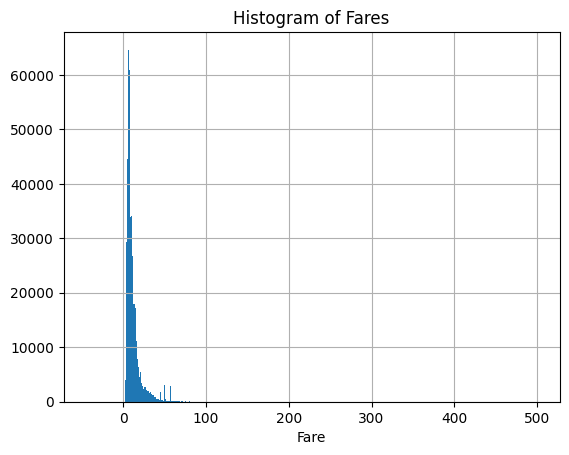

In [19]:
# 요금 데이터가 의심스러움. 히스토그램으로 분포 확인

df['fare_amount'].hist(bins=500)
plt.xlabel("Fare")
plt.title("Histogram of Fares")
plt.show()

In [20]:
# 500달러는 이상치일 가능성 높다. 100달러 이상의 값은 제거한다.
df = df[(df['fare_amount']>=0) & (df['fare_amount'] <= 100)]

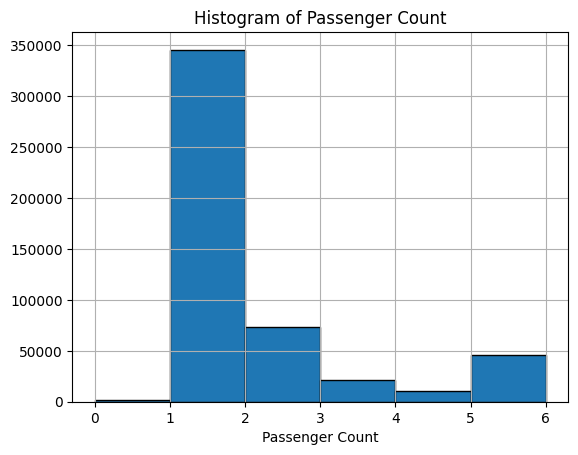

In [21]:
# 승객 칼럼도 확인
df['passenger_count'].hist(bins=6, ec='black')
plt.xlabel("Passenger Count")
plt.title("Histogram of Passenger Count")
plt.show()

In [22]:
# 승객수가 0인 값은 최빈값 즉, 1명이라고 간주

df.loc[df['passenger_count']==0, 'passenger_count'] = 1

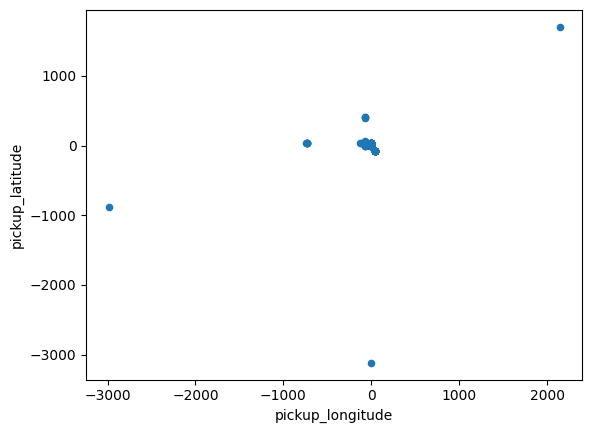

In [23]:
# 승차 및 하차 위치의 이상치 확인, 뉴욕시 경계 제한 없이 그려본다
df.plot.scatter('pickup_longitude', 'pickup_latitude')
plt.show()

In [25]:
# 가장자리 점들은 모두 이상치, 위도와 경도가 1000, -3000 이 될 수 없다. 제거한다
# 뉴욕시 내 위치로 한정
for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[long] > min_longitude) & (df[long] < max_longitude)]
             
for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[lat] > min_latitude) & (df[lat] < max_latitude)]


## 특징 공학

### 시간 관련 변수
앞서 pickup_datetime 칼럼을 year, month, day, day_of_week, hour로 나눴다. 

In [26]:
print(df.head())

                             key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  year  month  day  day_of_week  hour  
0                1  2009    

In [28]:
# pickup_datetime 칼럼 제거
df = df.drop(['pickup_datetime'], axis=1)

### 위치 특징 변수
승차 위치와 하차 위치 정보를 사용해 거리를 계산하고 새로운 변수로 추가한다  
운행 거리는 유클리드 거리로 계산한다.  
유클리드 거리 = ((x2-x1)^2+(y2-y1)^2)^0.5

In [29]:
# 유클리드 거리 계산 함수
def euc_distance(lat1, long1, lat2, long2):
    return(((lat2-lat2)**2 + (long1-long2)**2)**0.5)

In [30]:
# DataFrame에 적용해 distance 칼럼 추가
df['distance'] = euc_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude']) 

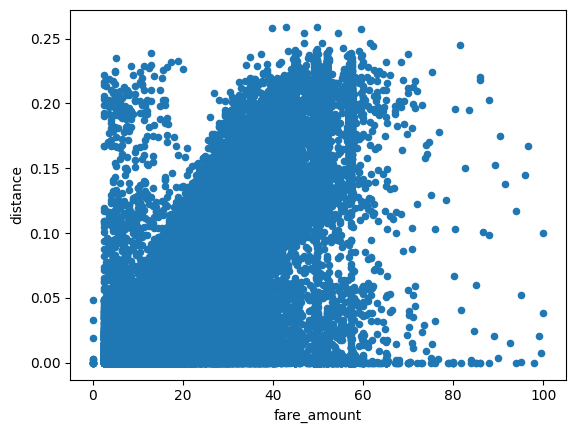

In [31]:
# 거리와 요금과의 관계 확인, 점차트로 상관성 분석
df.plot.scatter('fare_amount', 'distance')
plt.show()

In [32]:
# 주요 공항과 승차 및 하차 위치 사이의 거리 계산
airports = {'JFK Airport' : (-73.78, 40.643),
            'Laguardia Airport' : (-73.87, 40.77), 
            'Newark_Airport' : (-74.18, 440.69)}

for airport in airports:
    df['pickup_dist_' + airport] = euc_distance(df['pickup_latitude'], df['pickup_longitude'], airports[airport][1], airports[airport][0])
    df['dropoff_dist_' + airport] = euc_distance(df['dropoff_latitude'], df['dropoff_longitude'], airports[airport][1], airports[airport][0])

In [33]:
print(df.head())

                             key  fare_amount  pickup_longitude  \
0    2009-06-15 17:26:21.0000001          4.5        -73.844311   
1    2010-01-05 16:52:16.0000002         16.9        -74.016048   
2   2011-08-18 00:35:00.00000049          5.7        -73.982738   
3    2012-04-21 04:30:42.0000001          7.7        -73.987130   
4  2010-03-09 07:51:00.000000135          5.3        -73.968095   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.721319         -73.841610         40.712278                1   
1        40.711303         -73.979268         40.782004                1   
2        40.761270         -73.991242         40.750562                2   
3        40.733143         -73.991567         40.758092                1   
4        40.768008         -73.956655         40.783762                1   

   year  month  day  day_of_week  hour  distance  pickup_dist_JFK Airport  \
0  2009      6   15            0    17  0.002701               

In [34]:
# key 값은 삭제해도 손실없음
df = df.drop(['key'], axis=1)

## 변수 스케일링
모든 독립변수 값을 동일한 범위로 변환  
변수 스케일링을 적용하기 전에 DataFrame을 복사하고 원본을 유지하는 것이 좋다. 

In [35]:
df_prescaled = df.copy()

In [36]:
# 종속 변수는 스케일링 하지 않는다. 따라서 제거
df_scaled = df.drop(['fare_amount'], axis=1)

In [37]:
# 변수 스케일링 적용
from sklearn.preprocessing import scale
df_scaled = scale(df_scaled)

In [38]:
# scale함수가 반환한 객체를 판다스 DataFrame으로 변환하고 원본의 fare_amount 칼럼을 붙여서 마무리 한다.
cols = df.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
df_scaled = pd. concat([df_scaled, df['fare_amount']], axis=1)
df = df_scaled.copy()

In [39]:
print(df.head())

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0          3.916896        -1.128227           4.151116         -1.365537   
1         -1.203464        -1.510227          -0.146055          1.083475   
2         -0.210322         0.395464          -0.519838         -0.020874   
3         -0.341270        -0.677271          -0.529984          0.243605   
4          0.226261         0.652445           0.559839          1.145221   

   passenger_count      year     month       day  day_of_week      hour  \
0        -0.526888 -1.469611 -0.078187 -0.078219    -1.560801  0.535442   
1        -0.526888 -0.932852 -1.531625 -1.230176    -1.047515  0.381408   
2         0.239932 -0.396092  0.503188  0.267369    -0.020945 -2.083145   
3        -0.526888  0.140667 -0.659562  0.612956     1.005625 -1.467007   
4        -0.526888 -0.932852 -0.950250 -0.769393    -1.047515 -1.004903   

   distance  pickup_dist_JFK Airport  dropoff_dist_JFK Airport  \
0 -0.598232         

## 심층 전방향 신경망

### 모델 아키텍처
은닉레이어 4개  
첫번째 레이어 노드 128, 이후 절반씩 감소  
작게 만들고 필요에 따라 복잡도를 늘리는 것이 좋다.  
활성화 함수는 비선형 함수인 ReLU를 사용  
회귀모델이므로 출력레이어의 노드는 1개  

### 회귀 손실 함수
회귀 문제에서는 RMSE(Root Mean squared Error)를 오차 지표로 사용한다.  
RMSE = ((예측값-실제값)**2)**0.5  

## 케라스로 모델 만들기
케라스의 Sequential 클래스를 사용해서 모델 만든다

In [40]:
# DataFrame을 훈련 데이터셋과 테스트 데이터셋으로 나눈다

# 독립변수와 종속변수로 구분
X = df.loc[:, df.columns != 'fare_amount']
y = df.fare_amount

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
# 케라스 신경망을 구축한다

from keras.models import Sequential
from keras.layers import Dense

model=Sequential()
model.add(Dense(128, activation= 'relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(8, activation= 'relu'))
model.add(Dense(1))

In [43]:
# 모델 구조 검증
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 12913 (50.44 KB)
Trainable params: 12913 (50.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# 신경망 컴파일 및 훈련

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

model.fit(X_train, y_train, epochs=1)




12086/12086 [==============================] - 10s 758us/step - loss: 14.1141 - mse: 14.1141


## 결과 분석
테스트 데이터셋에서 무작위로 샘플을 뽑아 요금을 예측하는 함수

In [46]:
def predict_random(df_prescaled, X_test, model):
    sample = X_test.sample(n=1, random_state=np.random.randint(low=0, high=10000))
    idx = sample.index[0]

    actual_fare = df_prescaled.loc[idx,'fare_amount']
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_of_week = day_names[df_prescaled.loc[idx,'day_of_week']]
    hour = df_prescaled.loc[idx,'hour']
    predicted_fare = model.predict(sample)[0][0]
    rmse = np.sqrt(np.square(predicted_fare-actual_fare))

    print("Trip Details: {}, {}:00hrs".format(day_of_week, hour))
    print("Actual fare: ${:0.2f}".format(actual_fare))
    print("Predicted fare: ${:0.2f}".format(predicted_fare))
    print("RMSE: ${:0.2f}".format(rmse))

predict_random 함수는 테스트 데이터셋에서 무작위로 ㄹ우를 하나 뽑아 모델에 전달하고 예측값을 산출한다.   
그런다음 RMSE를 계산해 출력한다. 스케일이 바뀐 상태로 출력되기 때문에 df_prescaled를 사용해 요일과 시간의 원래 값을 알아낸다. 

In [47]:
predict_random(df_prescaled, X_test, model)

1/1 [==============================] - 0s 70ms/step
Trip Details: Saturday, 2:00hrs
Actual fare: $26.04
Predicted fare: $25.15
RMSE: $0.89


In [48]:
# 전체 훈련 데이터셋과 테스트 데이터셋의 RMSE 계산
from sklearn.metrics import mean_squared_error

# 결과를 분석한다
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Train RMSE: {:0.2f}".format(train_rmse))
print("Test RMSE: {:0.2f}".format(test_rmse))
print('------------------------')


3022/3022 [==============================] - 2s 552us/step
Train RMSE: 3.55
Test RMSE: 3.56
------------------------


RMSE가 3.56 이라는 것은 평균 3.56 달러의 오차로 예측할 수 있다는 의미.   
RMSE는 예측값과 실제 값 사이의 오차의 제곱 평균의 제곱근으로, 값이 작을수록 모델의 예측이 실제 값과 가깝다.